# DID analysis about the number of submissions

## Install and import packages

In [1]:
# 必要なパッケージをインストール
%pip install pandas statsmodels matplotlib seaborn

# パッケージの読み込み
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load data

In [2]:
# Load the two CSV files
file_treatment = "./combined_texts_Palestine_Israel_IsraelPalestine_20241118_151608.csv"
file_control = "./combined_texts_ps4homebrew_Exercise_voyageons_20241118_180836.csv"

# Reading the treatment and control group data
df_treatment = pd.read_csv(file_treatment)
df_control = pd.read_csv(file_control)

# Display basic information about the datasets to understand their structure
df_treatment.info(), df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261421 entries, 0 to 261420
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         260299 non-null  object
 1   created_utc  261419 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15236 entries, 0 to 15235
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         15084 non-null  object
 1   created_utc  15236 non-null  object
dtypes: object(2)
memory usage: 238.2+ KB


(None, None)

## Grouping data into treatment or control

In [3]:
# Convert 'created_utc' to datetime and create treatment/control dummy variables
df_treatment['created_utc'] = pd.to_datetime(df_treatment['created_utc'], utc=True)
df_control['created_utc'] = pd.to_datetime(df_control['created_utc'], utc=True)

# Add group identifier: 1 for treatment, 0 for control
df_treatment['group'] = 1
df_control['group'] = 0

# Merge both datasets for analysis
df_combined = pd.concat([df_treatment, df_control], ignore_index=True)

# Create a binary variable for pre- and post- October 1, 2024
cutoff_date = pd.to_datetime('2024-10-01', utc=True)
df_combined['post_treatment'] = (df_combined['created_utc'] >= cutoff_date).astype(int)

# Group by day to count number of submissions per day for each group
df_combined['date'] = df_combined['created_utc'].dt.date
daily_counts = df_combined.groupby(['date', 'group', 'post_treatment']).size().reset_index(name='submission_count')

# Display the resulting daily submission counts
daily_counts.head()

,date,group,post_treatment,submission_count
0,2024-07-28,0,0,14
1,2024-07-28,1,0,945
2,2024-07-29,0,0,72
3,2024-07-29,1,0,1743
4,2024-07-30,0,0,44


## Create model and output summary

In [4]:
import statsmodels.api as sm

# Create the interaction term for DID
daily_counts['interaction'] = daily_counts['group'] * daily_counts['post_treatment']

# Calculate weights based on inverse group size
group_sizes = daily_counts.groupby('group').size()
weights = daily_counts['group'].map(group_sizes).rdiv(1)  # 1 / group size

# Define the independent variables (X) and the dependent variable (y)
X = sm.add_constant(daily_counts[['group', 'post_treatment', 'interaction']])
y = daily_counts['submission_count']

# Fit the WLS model with weights
did_model_wls = sm.WLS(y, X, weights=weights).fit()

# Output the summary of the DID regression results
print(did_model_wls.summary())

                            WLS Regression Results                            
Dep. Variable:       submission_count   R-squared:                       0.499
Model:                            WLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     74.07
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           2.82e-33
Time:                        18:38:53   Log-Likelihood:                -1911.5
No. Observations:                 227   AIC:                             3831.
Df Residuals:                     223   BIC:                             3845.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            143.9538    137.773      1.

## Visualization

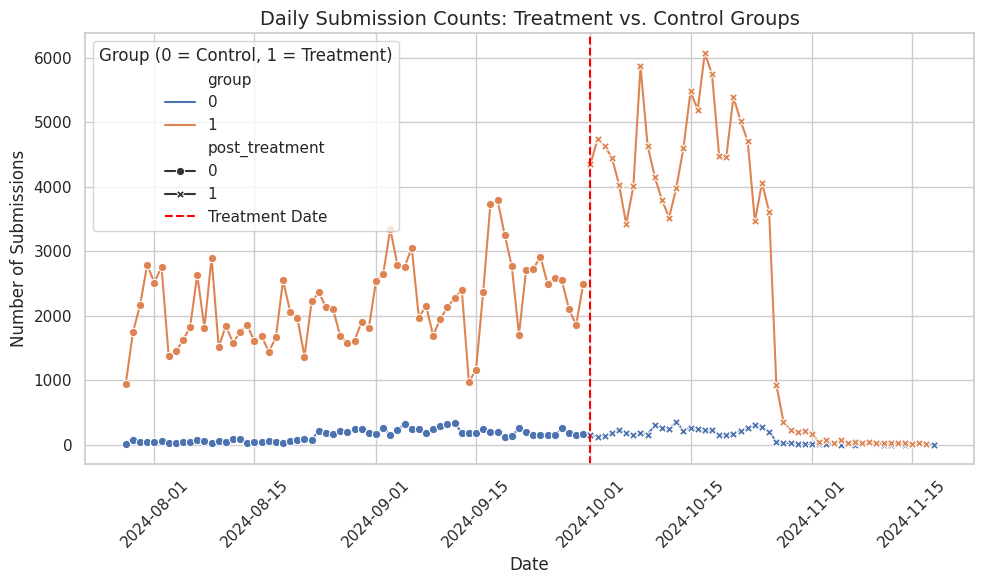

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Plot daily submission counts for treatment and control groups, before and after the treatment date
plt.figure(figsize=(10, 6))

# Plot submission counts over time for treatment and control groups
sns.lineplot(data=daily_counts, x='date', y='submission_count', hue='group', style='post_treatment', markers=True, dashes=False)

# Add vertical line indicating the treatment date
plt.axvline(pd.to_datetime('2024-10-01'), color='red', linestyle='--', label='Treatment Date')

# Labels and title
plt.title('Daily Submission Counts: Treatment vs. Control Groups', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.legend(title='Group (0 = Control, 1 = Treatment)')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
